In [91]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

In [92]:
%matplotlib widget

# ATARI Sammy Interface

This user example details basic use of the ATARI/SAMMY interface module. 
The example given here shows how to do individual sammy runs using the NV or IQ solution scheme.
The AutoFit example will detail sammy interface with YW scheme that can be used for automatic evaluations or simultaneous data fitting.

In [93]:
### setup the reaction model and sample a resonance
Ta_pair = Particle_Pair()      

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=8.79,
                       gn2_avg=465,
                       gn2_dof=1,
                       gg2_avg=350,
                       gg2_dof=1000)

# setup experimental transmission model
exp_model_T = Experimental_Model()


# calculate experimentally corrected transmission or capture yield with sammy
rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR_1"
                                         })

template_creator.make_input_template(
    'template_T.inp', Ta_pair, exp_model_T, rto)
exp_model_T.template = os.path.realpath('template_T.inp')



In [94]:
### Generate syndat from measurement models
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.control import Syndat_Model, syndatOPT


generative = Transmission_RPI()
reductive = Transmission_RPI()

synOPT = syndatOPT(calculate_covariance=True, explicit_covariance=True)

synT = Syndat_Model(
              exp_model_T,
              generative,
              reductive,
              synOPT)
## need to test syndat covariance generation with different tof ordering !!!

synT.sample(Ta_pair, 
            sammyRTO=rto,
            num_samples=1)

In [95]:
vars(generative.model_parameters)

{'trigo': (9758727, 0),
 'trigs': (18476117, 0),
 'm1': (1, 0.016),
 'm2': (1, 0.008),
 'm3': (1, 0.018),
 'm4': (1, 0.005),
 'ks': (0.563, 0.02402339737495515),
 'ko': (1.471, 0.05576763648617445),
 'b0s': (9.9, 0.1),
 'b0o': (13.4, 0.7),
 'a_b': ([582.7768594580712, 0.05149689096209191],
  [[1143.95753, 0.142659922], [0.142659922, 2.19135003e-05]]),
 'open_neutron_spectrum':                tof            bw     c         dc           E
 0    183110.960936  9.999999e-08  1226  35.014283  200.200037
 1    183010.960948  9.999998e-08  1206  34.727511  200.422933
 2    182910.960963  1.000001e-07  1167  34.161382  200.646202
 3    182810.960863  9.999996e-08  1182  34.380227  200.869845
 4    182710.960904  1.000001e-07  1124  33.526109  201.093861
 ..             ...           ...   ...        ...         ...
 184  164710.960895  9.999999e-08  1236  35.156792  248.453308
 185  164610.960907  9.999995e-08  1312  36.221541  248.761496
 186  164510.960956  1.000000e-07  1305  36.124784  24

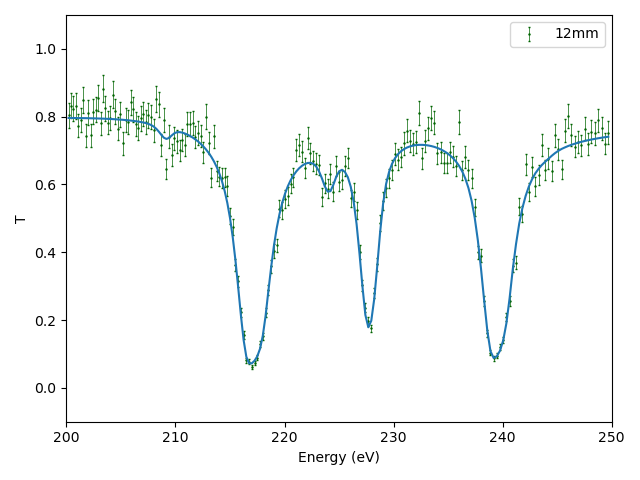

In [96]:
datasample = synT.samples[0]
data = datasample.pw_reduced


figure()
errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')
plot(data.E, data.true)
ylabel("T")

xlim([200,250])
ylim([-0.1,1.1])
legend()
xlabel('Energy (eV)')
tight_layout()

In [97]:
### Option to read in idc or you can just pass to sammy a filepath


# def read_idc(filepath):
#     data = {
#         'J': {},
#         'C': None,
#         'stat': None
#     }

#     with open(filepath, 'r') as f:
#         num_params = None
#         in_partial_derivatives = False
#         in_uncertainties = False
#         in_correlations = False
#         for line in f.readlines():
            
#             if line.lower().startswith("nu"):
#                 num_params = int(line.split()[-1])
            
#             elif line.lower().startswith("free-forma"):
#                 in_partial_derivatives = True

#             elif line.lower().startswith("uncertaint"):
#                 in_partial_derivatives = False
#                 in_uncertainties = True
            
#             elif line.lower().startswith("correlatio"):
#                 in_uncertainties = False
#                 in_correlations = True

#             elif in_partial_derivatives:
#                 splitline = line.split()
#                 E = float(splitline[0])
#                 stat_unc = float(splitline[1])
#                 derivatives = [float(x) for x in splitline[2:]]
#                 data['J'][E] = {'stat_unc': stat_unc, 'derivatives': derivatives}
                
#             elif in_uncertainties:
#                 uncertainties = [float(e) for e in line.split()]
#                 data['C'] = np.diag(uncertainties)

#             elif in_correlations:
#                 assert isinstance(num_params, int)
#                 correlations = []
#                 for _ in range(num_params):
#                     line = f.readline().strip().split()
#                     correlations.append([float(x) for x in line])

#     data['stat'] = None  # You need to fill in the logic for reading the 'stat' data

#     return data

# Usage
filepath = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-1mm.idc'
# read_data = read_idc(filepath)

In [98]:
print(datasample.covariance_data.keys())

dict_keys(['CovT', 'diag_stat', 'Cov_sys', 'Jac_sys'])


In [99]:
datasample.covariance_data['CovT']

E,200.200037,200.422933,200.646202,200.869845,201.093861,201.318253,201.543020,201.768164,201.993685,202.219584,...,246.920925,247.226266,247.532173,247.838648,248.145693,248.453308,248.761496,249.070258,249.379595,249.689508
200.200037,0.001297,0.000396,0.000392,0.000396,0.000369,0.000376,0.000405,0.000355,0.000387,0.000355,...,0.000345,0.000340,0.000364,0.000343,0.000360,0.000357,0.000376,0.000365,0.000343,0.000359
200.422933,0.000396,0.001354,0.000406,0.000410,0.000382,0.000389,0.000419,0.000367,0.000401,0.000367,...,0.000358,0.000353,0.000377,0.000355,0.000373,0.000370,0.000389,0.000378,0.000355,0.000372
200.646202,0.000392,0.000406,0.001382,0.000406,0.000378,0.000385,0.000415,0.000364,0.000397,0.000364,...,0.000354,0.000349,0.000373,0.000352,0.000369,0.000366,0.000385,0.000374,0.000351,0.000368
200.869845,0.000396,0.000410,0.000406,0.001402,0.000382,0.000389,0.000419,0.000367,0.000401,0.000367,...,0.000358,0.000352,0.000377,0.000355,0.000373,0.000370,0.000389,0.000378,0.000355,0.000371
201.093861,0.000369,0.000382,0.000378,0.000382,0.001228,0.000362,0.000390,0.000342,0.000373,0.000342,...,0.000333,0.000328,0.000351,0.000330,0.000347,0.000344,0.000362,0.000351,0.000330,0.000346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248.453308,0.000357,0.000370,0.000366,0.000370,0.000344,0.000351,0.000378,0.000331,0.000361,0.000331,...,0.000323,0.000318,0.000340,0.000320,0.000336,0.001112,0.000351,0.000341,0.000320,0.000335
248.761496,0.000376,0.000389,0.000385,0.000389,0.000362,0.000369,0.000397,0.000348,0.000380,0.000348,...,0.000339,0.000334,0.000357,0.000337,0.000353,0.000351,0.001229,0.000358,0.000336,0.000352
249.070258,0.000365,0.000378,0.000374,0.000378,0.000351,0.000358,0.000386,0.000338,0.000369,0.000338,...,0.000329,0.000324,0.000347,0.000327,0.000343,0.000341,0.000358,0.001139,0.000327,0.000342
249.379595,0.000343,0.000355,0.000351,0.000355,0.000330,0.000337,0.000362,0.000318,0.000346,0.000318,...,0.000309,0.000305,0.000326,0.000307,0.000322,0.000320,0.000336,0.000327,0.000996,0.000321


In [100]:
# ### decomposed covariance test
# stat = copy(datasample.covariance_data["diag_stat"])
# CT = copy(datasample.covariance_data['CovT'])
# J = copy(datasample.covariance_data['Jac_sys'])
# C = copy(datasample.covariance_data['Cov_sys'])
# # C = np.diag(np.diag(C))
# test = J.T@C@J
# test.index.name = None
# assert(np.max(abs((np.diag(stat.var_stat) + test) - CT)) == 0.0)

# Fit the data with sammy

In [101]:
rto.bayes=True
rto.get_ECSCM = True
rto.ECSCM_rxn = 'transmission'

sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    Ta_pair.resonance_ladder,
    os.path.realpath('template_T.inp'),
    exp_model_T,
    # energy_grid=exp_model_T.energy_grid
    experimental_data=data,
    experimental_covariance = datasample.covariance_data
)

sammyINP.initial_parameter_uncertainty=10

# std = 0.01
# data.exp = np.random.default_rng().normal(data.true, std)
# data.exp_unc = std

sammyINP.experimental_data = data
sammyINP.resonance_ladder["varyE"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGg"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGn1"] = np.ones(len(Ta_pair.resonance_ladder))

sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
print(sammyOUT2.chi2_post)
print(sammyOUT2.chi2n_post)

339.217
1.7948


BACKGround functions
EXPON 0 0 582.77685 33.822441 0.0514968 0.0046811 

NORMALIZATION AND BACKGROUND ARE NEXT
1.0000000        0.0                                         3
0.0384200

!! when fitting background or normalization, the output lst has an additional column I need to be robust to.

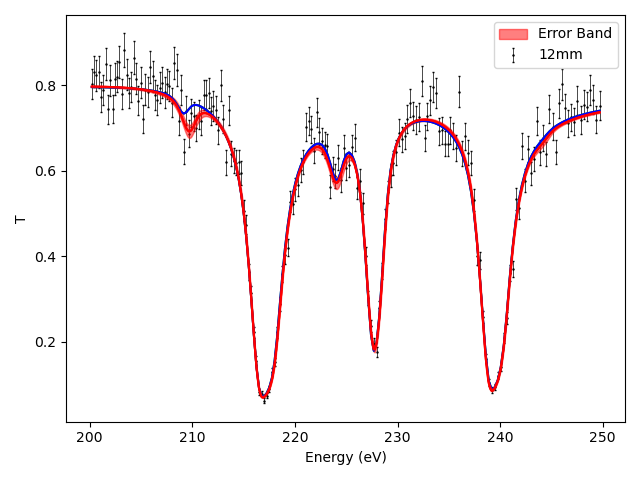

In [102]:

### Plot 
figure()

errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

plot(data.E, data.true, 'g')

plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_trans, 'b')
plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_trans_bayes, 'r')

# plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_xs, 'b')
# plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_xs_bayes, 'r')
# # plot(sammyOUT_old.est_df.E, sammyOUT_old.est_df.theo, 'b')
# # sammyOUT_old = copy(sammyOUT2)

x = sammyOUT2.est_df.E
y = sammyOUT2.est_df.theo
y_err=  sammyOUT2.est_df.theo_unc #
# y_err = np.sqrt(np.diag(sammyOUT2.ECSCM))
fill_between(x, y - y_err, y + y_err, color='r', alpha=0.5, label='Error Band')
plot(x, y, 'r')

ylabel("T")

# xlim([200,225])
# ylim([-0.1,1.1])
legend()

xlabel('Energy (eV)')
tight_layout()


# figure()
# imshow(sammyOUT2.ECSCM)
# colorbar()

In [103]:
ladder = copy(sammyOUT2.par_post)
print(ladder)
Ta_pair.spin_groups

            E           Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0  209.616490  1075.922880   0.487355    1.0     1.0      1.0   1.0
1  217.117070   675.463280  33.173060    1.0     1.0      1.0   1.0
2  223.963749   942.978723   0.855623    1.0     1.0      1.0   1.0
3  227.734592   706.049014   8.204369    1.0     1.0      1.0   1.0
4  239.382265   531.504877  36.171285    1.0     1.0      1.0   1.0
5  243.997555   597.667990   0.061355    1.0     1.0      1.0   1.0


{3.0: {'Jpi': 3.0,
  'J_ID': 1,
  '<D>': 8.79,
  '<gn2>': 465,
  'n_dof': 1,
  '<gg2>': 350,
  'g_dof': 1000,
  'quantiles': {'D01': 0.9943384234177864,
   'D99': 21.284662911191237,
   'gn01': 0.07304585392801136,
   'gn99': 3085.2269194748646,
   'gg01': 314.61935642536463,
   'gg99': 387.43914802327606,
   'gt01': 314.69240227929265,
   'gt99': 3472.666067498141},
  'chs': 1,
  'Ls': [0]}}

In [104]:
from ATARI.utils.atario import expand_sammy_ladder_2_atari

expand_sammy_ladder_2_atari(Ta_pair, ladder)
ladder

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID,gg2,gn2,Jpi,L
0,209.616490,1075.922880,0.487355,1.0,1.0,1.0,1.0,537.961440,9.479700,3.0,0.0
1,217.117070,675.463280,33.173060,1.0,1.0,1.0,1.0,337.731640,634.016317,3.0,0.0
2,223.963749,942.978723,0.855623,1.0,1.0,1.0,1.0,471.489361,16.101092,3.0,0.0
3,227.734592,706.049014,8.204369,1.0,1.0,1.0,1.0,353.024507,153.106128,3.0,0.0
4,239.382265,531.504877,36.171285,1.0,1.0,1.0,1.0,265.752438,658.384865,3.0,0.0
5,243.997555,597.667990,0.061355,1.0,1.0,1.0,1.0,298.833995,1.106154,3.0,0.0


In [105]:
# samples = 100

# cov_true = np.zeros([len(sammyOUT2.pw),len(sammyOUT2.pw)])
# cov_est = np.zeros([len(sammyOUT2.est_df),len(sammyOUT2.est_df)])

# for i in range(samples):
#     # synT.run(sammyOUT.pw)
#     data.exp = np.random.default_rng().normal(synT.data.true, std)
#     data.exp_unc = std
#     sammyINP.experimental_data = synT.data
#     sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#     residual = np.atleast_2d(sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#     cov_true += residual.T@residual
#     cov_est += sammyOUT2.ECSCM
#     # true.append(cov_true)
#     # est.append(cov_est)

In [106]:
# iest = 0
# fig, axes = subplots(1,2, figsize=(10,4))
# # im1 = axes[0].imshow(np.log10(cov_true/(samples)))
# # im2 = axes[1].imshow(np.log10(cov_est/(samples-1)))
# im1 = axes[0].pcolormesh(cov_true/(samples), clim=(-1e-5, 8e-5))
# im2 = axes[1].pcolormesh(cov_est/(samples-1), clim=(-1e-5, 8e-5))
# axes[0].set_title("empirical")

# axes[1].set_title("estimated")
# # for ax in axes:
# colorbar(im1)

# colorbar(im2)

# print("Empirical Fnorm")
# print(np.linalg.norm(cov_true/(samples), ord='fro'))
# print("Estimated Fnorm")
# print(np.linalg.norm(cov_est/(samples-1), ord='fro'))

In [107]:
# ### Plot 
# figure()

# # errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
# #                                         fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

# # plot(synT.data.E, synT.data.true, 'g')
# plot(synT.data.E, np.sqrt(np.diag(cov_true/samples)), label="empirical")
# plot(x, np.sqrt(np.diag(cov_est/(samples-1))), label="mean estimated")


# xlim([200,225])
# # ylim([-0.1,1.1])
# legend()

# xlabel('Energy (eV)')
# tight_layout()

In [108]:
# # result_dict = {}
# # stds = [0.1, 0.01, 0.001, 0.0001]
# stds = [0.00001, 0.05]

# for istd in stds:
#     samples = 1000
#     cov_true = np.zeros([len(sammyOUT2.pw), len(sammyOUT2.pw)])
#     cov_est = np.zeros([len(sammyOUT2.est_df), len(sammyOUT2.est_df)])
#     for i in range(samples):
#         # synT.run(sammyOUT.pw)
#         synT.data.exp = np.random.default_rng().normal(synT.data.true, istd)
#         synT.data.exp_unc = istd
#         sammyINP.experimental_data = synT.data
#         sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#         residual = np.atleast_2d(
#             sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#         cov_true += residual.T@residual
#         cov_est += sammyOUT2.ECSCM
        
#     result_dict[istd] = [cov_true, cov_est]

In [109]:
# stds = [1.0, 0.1, 0.05, 0.01, 0.001, 0.0001]
# true= []
# est = []

# for istd in stds:
#     res = result_dict[istd]
#     cov_true = res[0]
#     cov_est = res[1]
#     print(istd)
#     # print("Empirical Fnorm: ", np.linalg.norm(cov_true/(samples), ord='fro'))
#     # print("Estimated Fnorm: ", np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     # true.append(np.linalg.norm(cov_true/(samples), ord='fro'))
#     # est.append(np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     print("Empirical Fnorm: ", np.sum(np.diag(cov_true)**2/(samples)))
#     print("Estimated Fnorm: ", np.sum(np.diag(cov_est)**2/(samples-1)))
#     true.append(np.sum(np.diag(cov_true)**2/(samples)))
#     est.append(np.sum(np.diag(cov_est)**2/(samples-1)))

In [110]:
# figure()
# plot(stds, true, '.', label='Empirical')
# plot(stds, est, '.r', label='Estimate')
# xscale("log")
# yscale("log")
# legend()
# # ylabel("Noise Level")
# xlabel("Noise Level")